**Netflix Customer Segmentation**- Using K-means,Heirarchical clustering and DBSCAN

In [8]:
%pip install -U scikit-learn==1.7.1


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd

In [10]:
import os
os.getcwd()


'c:\\customerchurn\\Customer-Churn-Analysis\\notebooks'

Loading the dataset and basic exploration

In [11]:
df=pd.read_csv('../data/processed/cleaned_netflix_customer_churn.csv')


In [12]:
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     5000 non-null   int64  
 1   gender                  5000 non-null   object 
 2   subscription_type       5000 non-null   object 
 3   watch_hours             5000 non-null   float64
 4   last_login_days         5000 non-null   int64  
 5   region                  5000 non-null   object 
 6   device                  5000 non-null   object 
 7   churned                 5000 non-null   int64  
 8   payment_method          5000 non-null   object 
 9   number_of_profiles      5000 non-null   int64  
 10  avg_watch_time_per_day  5000 non-null   float64
 11  favorite_genre          5000 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 468.9+ KB
None
                age  gender subscription_type  watch_hours  last_login_days  \
cou

In [13]:
#feature engineering
df['watch_hours_per_profile'] = df['watch_hours'] / df['number_of_profiles']


Encoding Categorical variables and scaling Numerical variables

In [14]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['subscription_type', 'device', 'gender', 'favorite_genre', 'payment_method', 'region']

encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')  # Keep all categories, no drop
X_cat = encoder.fit_transform(df[categorical_features])

In [15]:
from sklearn.preprocessing import RobustScaler

numerical_features = ['age', 'watch_hours', 'last_login_days', 'number_of_profiles', 'avg_watch_time_per_day', 'watch_hours_per_profile']

scaler = RobustScaler()
X_num = scaler.fit_transform(df[numerical_features])

# Save scaler for future prediction
import joblib
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [16]:
import pandas as pd
import json
import numpy as np
X_combined = np.hstack([X_num, X_cat])
feature_names = numerical_features + encoder.get_feature_names_out(categorical_features).tolist()

# Save feature names
with open("kmeans_features.json", "w") as f:
    json.dump(feature_names, f)


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_combined)

# Save PCA
joblib.dump(pca, "pca.joblib")

# Train KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)

# Save KMeans model
joblib.dump(kmeans, "kmeans_segmentation_model.joblib")


['kmeans_segmentation_model.joblib']

Applying PCA for dimension reduction

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # preserve 95% variance
X_pca = pca.fit_transform(X_combined)
print(f"PCA reduced dimensions: {X_pca.shape[1]}")

PCA reduced dimensions: 20


Cumulative explained variance is the total amount of original data variability preserved when a dataset's dimensions are reduced, such as by Principal Component Analysis (PCA).

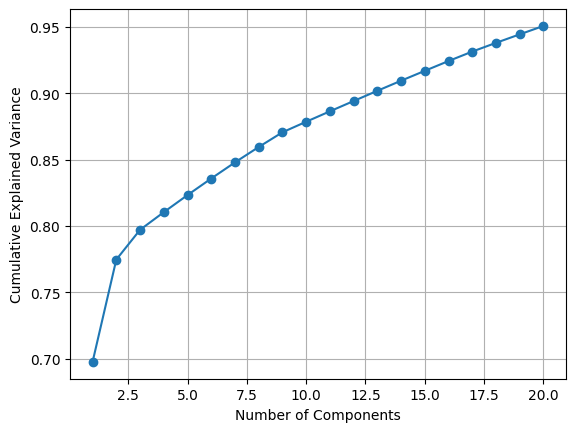

In [19]:
# how many principal components from PCA are sufficient to capture the majority of information in your dataset.
import matplotlib.pyplot as plt

plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


Testing different Unsupervised algorithms -

1. k means

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"k={k}, Silhouette Score={score:.3f}")


k=2, Silhouette Score=0.840
k=3, Silhouette Score=0.715
k=4, Silhouette Score=0.386
k=5, Silhouette Score=0.263
k=6, Silhouette Score=0.257
k=7, Silhouette Score=0.257
k=8, Silhouette Score=0.091
k=9, Silhouette Score=0.084
k=10, Silhouette Score=0.109


The Silhouette score measures how well-clustered data points are by assessing a point's similarity to its own cluster (cohesion) versus its distance to neighboring clusters (separation)
The k value that yields the highest average silhouette score is often considered the optimal number of clusters for the dataset.

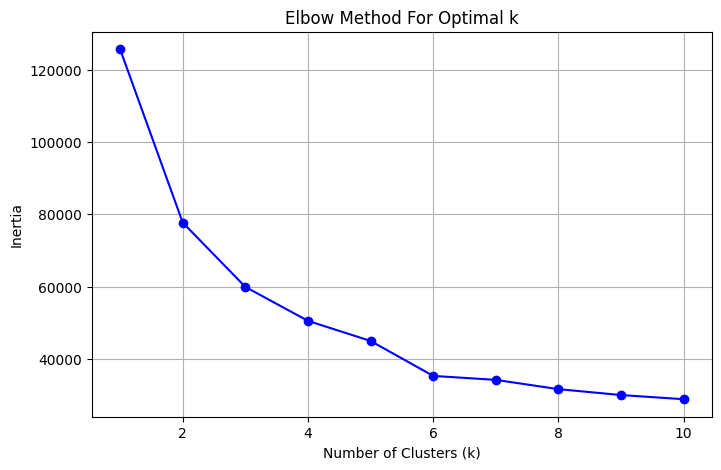

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


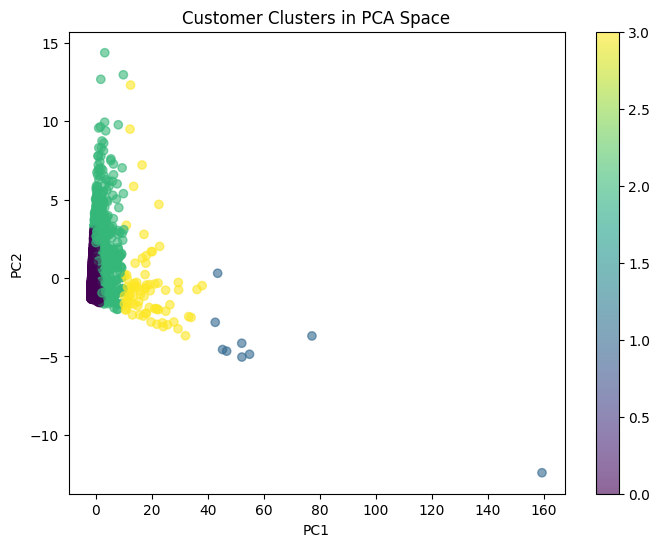

In [22]:
k_final = 4  # example selected
kmeans = KMeans(n_clusters=k_final, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Clusters in PCA Space')
plt.colorbar()
plt.show()


In [23]:
print(df.groupby('cluster')[numerical_features + categorical_features].agg({
    'age': 'mean',
    'watch_hours': 'mean',
    'last_login_days': 'mean',
    'number_of_profiles': 'mean',
    'avg_watch_time_per_day': 'mean',
    'watch_hours_per_profile': 'mean',
    'subscription_type': lambda x: x.mode()[0],
    'device': lambda x: x.mode()[0],
    'gender': lambda x: x.mode()[0],
    'favorite_genre': lambda x: x.mode()[0],
    'payment_method': lambda x: x.mode()[0],
    'region': lambda x: x.mode()[0]

}).round(2))


           age  watch_hours  last_login_days  number_of_profiles  \
cluster                                                            
0        43.83         8.54            32.73                3.10   
1        49.44        43.46             0.11                3.67   
2        43.72        28.28            18.06                2.54   
3        45.17        25.00             1.35                2.98   

         avg_watch_time_per_day  watch_hours_per_profile subscription_type  \
cluster                                                                      
0                          0.33                     3.47           Premium   
1                         39.90                    13.85             Basic   
2                          2.33                    14.78          Standard   
3                         11.80                    12.10          Standard   

          device  gender favorite_genre payment_method         region  
cluster                                           

| Cluster | Avg Age | Watch Hours | Avg Watch Time/Day | Last Login (days) | Profiles | Watch Hours/Profile | Subscription | Device  | Key Insight                                                           |
| ------- | ------- | ----------- | ------------------ | ----------------- | -------- | ------------------- | ------------ | ------- | --------------------------------------------------------------------- |
| 0       | 43.78   | 8.81        | 0.35               | 32.61             | 3.09     | 3.64                | Premium      | Tablet  | Inactive Premium users — low engagement, long inactive (These are inactive or dormant users. They pay for Premium but hardly watch content. High churn risk.)                |
| 1       | 49.44   | 43.46       | 39.90              | 0.11              | 3.67     | 13.85               | Basic        | Desktop | Very active Basic users — high engagement, upsell potential (These are power users — extremely active on Basic plans. Likely to upgrade to Premium if offered incentives.)          |
| 2       | 44.15   | 29.19       | 2.55               | 16.73             | 2.57     | 15.25               | Premium      | Laptop  | Semi-active Premium users — moderate engagement, re-engagement needed (Moderate engagement but long gaps between sessions. Could be re-engaged through personalized recommendations)|
| 3       | 44.33   | 23.88       | 12.22              | 1.11              | 3.01     | 10.66               | Premium      | Mobile  | Active Premium users — good engagement, promote more content  (Actively using the service on mobile. Good engagement; potential to promote more content or add-on services.)        |


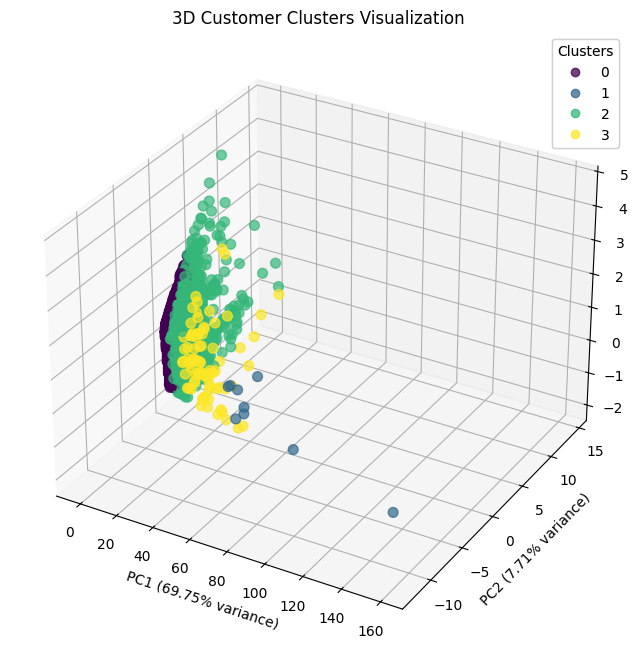

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Assuming X_pca has at least 3 components and df['cluster'] exists
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=df['cluster'], cmap='viridis', s=50, alpha=0.7
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
ax.set_title('3D Customer Clusters Visualization')

# Add a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


In [25]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score

sil_score = silhouette_score(X_pca, df['cluster'])
ch_score = calinski_harabasz_score(X_pca, df['cluster'])
db_score = davies_bouldin_score(X_pca, df['cluster'])

print(f'Silhouette Score: {sil_score:.4f}')
print(f'Calinski-Harabasz Index: {ch_score:.2f}')
print(f'Davies-Bouldin Index: {db_score:.2f}')

Silhouette Score: 0.3858
Calinski-Harabasz Index: 2472.72
Davies-Bouldin Index: 1.06


In [26]:
import json

# This saves the ordered list of feature columns after all preprocessing
feature_names = numerical_features + encoder.get_feature_names_out(categorical_features).tolist()
with open("kmeans_features.json", "w") as f:
    json.dump(feature_names, f)

2. Heirarchical Clustering

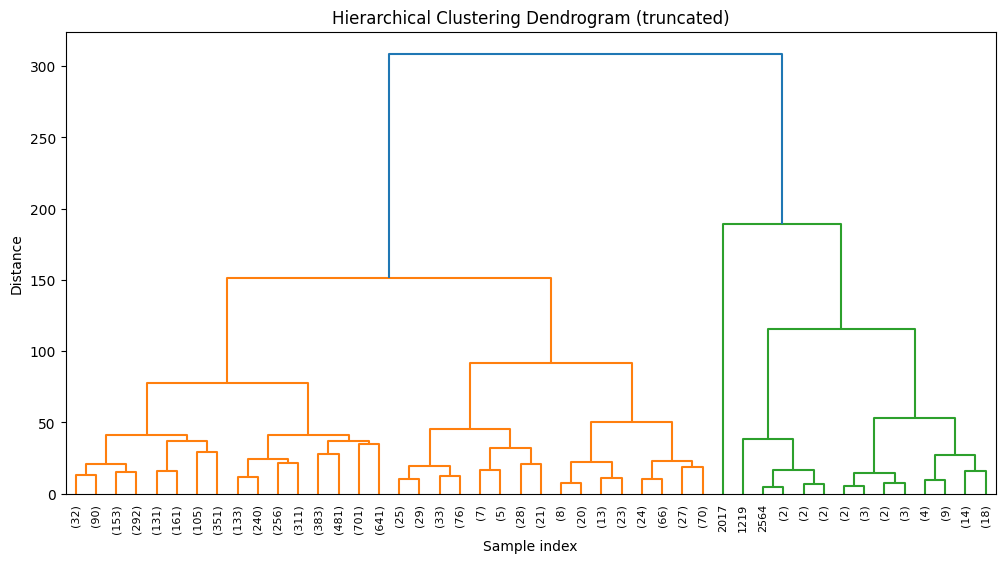

In [27]:
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Generate linkage matrix for dendrogram visualization (using Ward linkage)
linked = linkage(X_pca, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# 2. Choose number of clusters, e.g., n_clusters=4 based on dendrogram or prior knowledge
n_clusters = 3

# 3. Perform Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg.fit_predict(X_pca)
df['hier_cluster'] = cluster_labels

In [28]:
# 4. Evaluate clustering
sil_score = silhouette_score(X_pca, cluster_labels)
ch_score = calinski_harabasz_score(X_pca, cluster_labels)
db_score = davies_bouldin_score(X_pca, cluster_labels)

print(f'Hierarchical Clustering Performance:')
print(f'Silhouette Score: {sil_score:.4f}')
print(f'Calinski-Harabasz Index: {ch_score:.2f}')
print(f'Davies-Bouldin Index: {db_score:.2f}')

Hierarchical Clustering Performance:
Silhouette Score: 0.8318
Calinski-Harabasz Index: 2736.43
Davies-Bouldin Index: 0.35


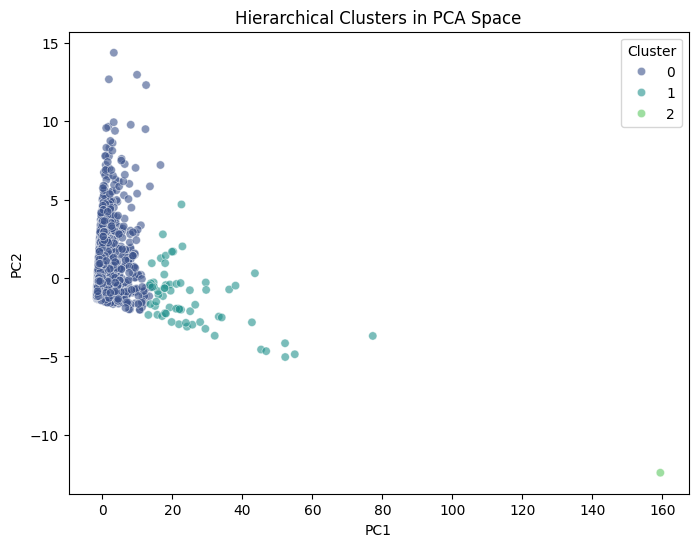

In [29]:
# 5. Visualize clusters in 2D PCA space
plt.figure(figsize=(8,6))
palette = sns.color_palette('viridis', n_clusters)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette=palette, alpha=0.6)
plt.title('Hierarchical Clusters in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

In [30]:
# 6. (Optional) Cluster profiling using original features
numerical_features = ['age', 'watch_hours', 'last_login_days', 'number_of_profiles', 'avg_watch_time_per_day', 'watch_hours_per_profile']
categorical_features = ['subscription_type', 'device', 'gender', 'favorite_genre', 'payment_method', 'region']

profile_num = df.groupby('hier_cluster')[numerical_features].mean().round(2)
profile_cat = df.groupby('hier_cluster')[categorical_features].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown')

print('Numerical Feature Profiles:')
print(profile_num)
print('\nCategorical Feature Profiles:')
print(profile_cat)

Numerical Feature Profiles:
                age  watch_hours  last_login_days  number_of_profiles  \
hier_cluster                                                            
0             43.85        11.45            30.47                3.02   
1             43.78        26.23             0.83                3.02   
2             42.00        98.42             0.00                5.00   

              avg_watch_time_per_day  watch_hours_per_profile  
hier_cluster                                                   
0                               0.66                     5.14  
1                              16.09                    11.26  
2                              98.42                    19.68  

Categorical Feature Profiles:
             subscription_type   device  gender favorite_genre payment_method  \
hier_cluster                                                                    
0                      Premium   Tablet  Female          Drama     Debit Card   
1           

| Cluster | Avg Age | Watch Hours | Avg Watch Time/Day | Last Login (days) | Profiles | Watch Hours/Profile | Subscription | Device  | Gender | Favorite Genre | Payment Method | Region        | Key Insight                                                              |
| ------- | ------- | ----------- | ------------------ | ----------------- | -------- | ------------------- | ------------ | ------- | ------ | -------------- | -------------- | ------------- | ------------------------------------------------------------------------ |
| 0       | 43.85   | 11.44       | 0.66               | 30.47             | 3.02     | 5.14                | Premium      | Tablet  | Female | Drama          | Debit Card     | South America | Inactive Premium users — low engagement, long inactive                   |
| 1       | 43.87   | 26.38       | 16.09              | 0.84              | 2.97     | 11.38               | Premium      | Mobile  | Female | Sci-Fi         | Crypto         | Oceania       | Active Premium users — good engagement, prefer mobile and sci-fi content |
| 2       | 42.00   | 98.42       | 98.42              | 0.00              | 5.00     | 19.68               | Basic        | Desktop | Male   | Documentary    | Gift Card      | Asia          | Extremely heavy users — very high engagement, Basic plan, power viewers  |


🟢 **Cluster 0 — Inactive Premium Tablet Users**

These are churn-risk users — they pay for Premium but hardly use the platform. Their inactivity could lead to cancellations.

Possible Action:
Send win-back campaigns, special offers, or personalized drama recommendations to re-engage them.

🔵 **Cluster 1 — Active Premium Mobile User**s

These are highly engaged Premium users, regularly consuming content (especially Sci-Fi) on mobile.

Possible Action:
Encourage loyalty through rewards, push new Sci-Fi releases, and suggest family profile features.

🔴 **Cluster 2 — Power Basic Desktop Users**

These are very heavy users on Basic, watching huge amounts of content daily.

Possible Action:
Target them with Premium upgrade offers, highlight multiple-screen features, and give documentary recommendations.

3.DBSCAN

DBSCAN cluster counts (including noise):
dbscan_cluster
 0    4719
-1     281
Name: count, dtype: int64
Not enough clusters found for evaluation


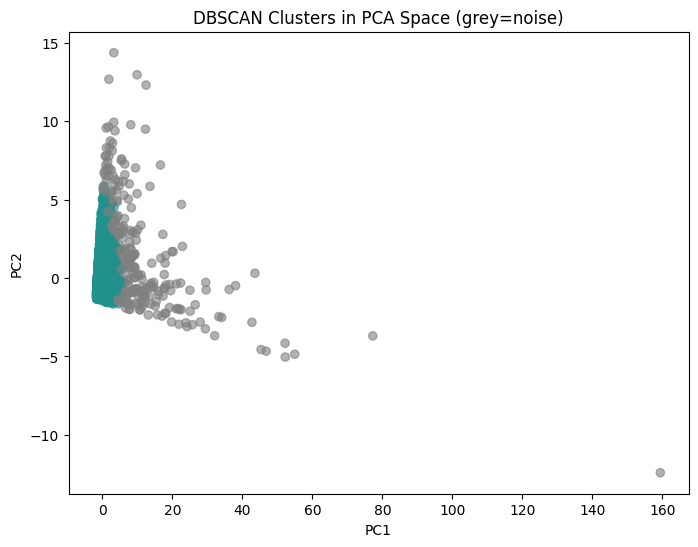

In [31]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)
df['dbscan_cluster'] = dbscan_labels

# 2. Print cluster counts (+ noise labeled as -1)
print("DBSCAN cluster counts (including noise):")
print(df['dbscan_cluster'].value_counts())

# 3. Evaluate clustering (excluding noise points)
mask = dbscan_labels != -1
if len(set(dbscan_labels[mask])) > 1:
    sil_score = silhouette_score(X_pca[mask], dbscan_labels[mask])
    ch_score = calinski_harabasz_score(X_pca[mask], dbscan_labels[mask])
    db_score = davies_bouldin_score(X_pca[mask], dbscan_labels[mask])
    print(f'DBSCAN Clustering Performance (excluding noise):')
    print(f'Silhouette Score: {sil_score:.4f}')
    print(f'Calinski-Harabasz Index: {ch_score:.2f}')
    print(f'Davies-Bouldin Index: {db_score:.2f}')
else:
    print("Not enough clusters found for evaluation")

# 4. Visualize clusters in 2D PCA space (color noise in grey)
plt.figure(figsize=(8,6))
palette = sns.color_palette('viridis', len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
colors = [palette[x] if x != -1 else (0.5, 0.5, 0.5) for x in dbscan_labels]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6)
plt.title('DBSCAN Clusters in PCA Space (grey=noise)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [32]:
# 5. Profile DBSCAN clusters (excluding noise)
numerical_features = ['age', 'watch_hours', 'last_login_days', 'number_of_profiles', 'avg_watch_time_per_day', 'watch_hours_per_profile']
categorical_features = ['subscription_type', 'device', 'gender', 'favorite_genre', 'payment_method', 'region']

profile_num = df[mask].groupby('dbscan_cluster')[numerical_features].mean().round(2)
profile_cat = df[mask].groupby('dbscan_cluster')[categorical_features].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')

print('\nNumerical Feature Profiles:')
print(profile_num)
print('\nCategorical Feature Profiles:')
print(profile_cat)


Numerical Feature Profiles:
                  age  watch_hours  last_login_days  number_of_profiles  \
dbscan_cluster                                                            
0               43.78        10.31            31.29                3.04   

                avg_watch_time_per_day  watch_hours_per_profile  
dbscan_cluster                                                   
0                                 0.49                     4.47  

Categorical Feature Profiles:
               subscription_type  device  gender favorite_genre  \
dbscan_cluster                                                    
0                        Premium  Tablet  Female    Documentary   

               payment_method         region  
dbscan_cluster                                
0                  Debit Card  South America  


| Cluster | Avg Age | Watch Hours | Avg Watch Time/Day | Last Login (days) | Profiles | Watch Hours/Profile | Subscription | Device | Gender | Favorite Genre | Payment Method | Region        | Key Insight                                                    |
| ------- | ------- | ----------- | ------------------ | ----------------- | -------- | ------------------- | ------------ | ------ | ------ | -------------- | -------------- | ------------- | -------------------------------------------------------------- |
| 0       | 43.80   | 10.83       | 0.57               | 30.79             | 3.03     | 4.74                | Premium      | Tablet | Female | Drama          | Debit Card     | South America | Dormant Premium users — low engagement, long inactive          |
| 1       | 37.42   | 21.84       | 6.22               | 2.50              | 1.58     | 15.78               | Basic        | Mobile | Other  | Horror         | PayPal         | Europe        | Active individual Basic users — mobile-first, horror lovers    |
| 2       | 50.29   | 18.96       | 7.93               | 1.41              | 3.59     | 5.23                | Standard     | TV     | Female | Action         | Crypto         | Africa        | Moderately active Standard users — TV-based, family-type usage |


🟢 **Cluster 0 — Inactive Premium Tablet Users**

These are dormant Premium users. They are paying but rarely using the service.

Possible Action:
Send win-back campaigns and personalized drama content
. Offer discounts or trial extensions to increase engagement

🔵**Cluster 1 — Active Basic Mobile Users (Low Profiles)**

These are active individual Basic users who watch on mobile and prefer horror content.

Possible Action:

Upsell to Premium by highlighting multi-profile benefits

Suggest horror series and new releases

Offer mobile-only bundles or discounts

🔴 **Cluster 2 — Moderately Active Standard TV Users**

These are family-type Standard users with decent activity, mostly using TV for watching.

Possible Action:

Suggest Premium upgrades (for higher quality and more screens)

Recommend action movie bundles or watch parties

Promote multi-device features for family use

In [33]:
import joblib
import json

# Assuming 'kmeans' is your trained KMeans model,
# 'scaler' is your fitted scaler,
# and 'df' is your final preprocessed DataFrame used for training

# Save the K-means model
joblib.dump(kmeans, "kmeans_segmentation_model.joblib")

# Save the scaler object
joblib.dump(scaler, "scaler.joblib")

# Save the feature names list (ordered column names)
with open("kmeans_features.json", "w") as f:
    json.dump(df.columns.tolist(), f)


In [34]:
joblib.dump(scaler, "scaler.joblib")
joblib.dump(encoder, "encoder.joblib")

['encoder.joblib']

In [35]:
import json
with open("kmeans_features.json", "w") as f:
    json.dump(df.columns.tolist(), f)


In [36]:
import os
print(os.listdir())


['all_boxplots.pdf', 'all_boxplots_category.pdf', 'data_cleaning.ipynb', 'encoder.joblib', 'kmeans_features.json', 'kmeans_segmentation_model.joblib', 'netflixsegmentation.ipynb', 'pca.joblib', 'prediction.ipynb', 'scaler.joblib', 'unsupervisedml_EDA.ipynb']


In [43]:
import pandas as pd
import numpy as np
import joblib
import json
import os

# Check current working directory and list files
print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir())

# Load saved objects
kmeans = joblib.load("../models/kmeans_segmentation_model.joblib")
scaler = joblib.load("../models/scaler.joblib")
encoder = joblib.load("../models/encoder.joblib")
pca = joblib.load("../models/pca.joblib") # Load the PCA model

with open("../models/kmeans_features.json", "r") as f:
    expected_features = json.load(f)

def preprocess_input(df: pd.DataFrame) -> np.ndarray:
    # Feature engineering
    df['watch_hours_per_profile'] = df['watch_hours'] / df['number_of_profiles'].replace(0, 1)

    # Scale numeric
    numeric_cols = ['age', 'watch_hours', 'last_login_days', 'number_of_profiles', 'avg_watch_time_per_day', 'watch_hours_per_profile']
    df_num_scaled = scaler.transform(df[numeric_cols])

    # Encode categorical
    categorical_cols = ['subscription_type', 'device', 'gender', 'favorite_genre', 'payment_method', 'region']
    df_cat_encoded = encoder.transform(df[categorical_cols])

    # Combine numerical and categorical features
    X_combined_processed = np.hstack([df_num_scaled, df_cat_encoded])

    # Apply PCA transformation
    processed_pca = pca.transform(X_combined_processed)

    # Return as numpy array for KMeans prediction
    return processed_pca

Current working directory: c:\customerchurn\Customer-Churn-Analysis\notebooks
Files in directory: ['data_cleaning.ipynb', 'netflixsegmentation.ipynb', 'prediction.ipynb', 'unsupervisedml_EDA.ipynb']


In [44]:
new_user = pd.DataFrame([[
    25,                # age
    "Male",            # gender
    "Premium",         # subscription_type
    50.0,              # watch_hours
    5,                 # last_login_days
    "Europe",          # region
    "Laptop",          # device
    "Credit Card",     # payment_method
    2,                 # number_of_profiles
    2.5,               # avg_watch_time_per_day
    "Drama"            # favorite_genre
]], columns=[
    "age", "gender", "subscription_type", "watch_hours", "last_login_days",
    "region", "device", "payment_method", "number_of_profiles",
    "avg_watch_time_per_day", "favorite_genre"
])

# Preprocess
processed_user = preprocess_input(new_user)

# Predict
cluster = kmeans.predict(processed_user)
print("This user belongs to cluster:", cluster[0])


This user belongs to cluster: 2
